# GPN Cup 2021
## Кирилл Захаров

#### Импорт библиотек

In [47]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import classification_report, confusion_matrix, mean_squared_error
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel
from gensim.models import Word2Vec

from tqdm.notebook import tqdm_notebook

import matplotlib.pyplot as plt
%matplotlib inline

In [249]:
transactions = pd.read_parquet('transactions.parquet')

In [250]:
transactions.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002335,0.000000,3338297,0.147929,78634.0,102,2171-07-23
1,1158,0.002317,0.000000,3386107,0.134562,20900.0,101,2171-07-23
2,1913,0.007850,0.000452,1845331,0.104183,96397.0,36,2171-07-23
3,1808,0.008979,0.000452,2256499,0.104183,103560.0,89,2171-07-23
4,1158,0.002355,0.000000,3257281,0.115023,67691.0,58,2171-07-23


In [251]:
len(transactions['client_id'].unique())

370083

In [252]:
len(transactions['sku_id'].unique())

4873

In [253]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7620119 entries, 0 to 7620118
Data columns (total 8 columns):
 #   Column     Dtype         
---  ------     -----         
 0   sku_id     int64         
 1   price      float64       
 2   number     float64       
 3   cheque_id  int64         
 4   litrs      float64       
 5   client_id  float64       
 6   shop_id    int64         
 7   date       datetime64[ns]
dtypes: datetime64[ns](1), float64(4), int64(3)
memory usage: 465.1 MB


In [254]:
transactions['client_id'].isna().any()

True

In [255]:
indx = np.where(transactions['client_id'].isna())[0]

In [256]:
len(indx)

3772355

In [257]:
transactions = transactions.dropna()

In [315]:
nomenclature = pd.read_parquet('nomenclature.parquet')

In [317]:
nomenclature.head()

,sku_id,full_name,brand,sku_group,OTM,units,country
0,0,Масло Lubricrol Magnatec Diesel 10W-40 B4 1л,Lubricrol,Масла моторные (для варповых двигателей),Нет,unknown,ГЕРМАНИЯ
1,723,Трос УранПРОМEthereum буксировочный 4500кг,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ
2,3397,Накидка УранПРОМEthereum на спинку автосиденья...,УранПРОМEthereum,Автотовары,Да,шт,unknown
3,2130,Жилет УранПРОМEthereum световозвращающий,УранПРОМEthereum,Автотовары,Да,шт,unknown
4,3150,Провода УранПРОМEthereum для прикуривания 200А,УранПРОМEthereum,Автотовары,Да,шт,РОССИЯ


In [318]:
nomenclature['full_name'] = nomenclature['full_name'].replace('unknown', None)

In [319]:
nomenclature.isna().sum()

sku_id          0
full_name    1379
brand           9
sku_group       0
OTM             9
units           9
country         9
dtype: int64

In [320]:
nomenclature['OTM'].value_counts() #для неизвестных данных используется unknown

Нет        3336
unknown    1370
Да          388
Name: OTM, dtype: int64

In [321]:
nomenclature = nomenclature.dropna()
nomenclature.isna().sum()

sku_id       0
full_name    0
brand        0
sku_group    0
OTM          0
units        0
country      0
dtype: int64

In [322]:
nomenclature.shape

(3724, 7)

#### Объединим таблицы в одну. Для каждого значения таблицы transactions добавим описание товара из таблицы nomenclature, для это замержим слева.

In [323]:
data = pd.merge(transactions, nomenclature, how='left', on=['sku_id'])
data.dropna(inplace=True)

In [324]:
data.head()

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date,full_name,brand,sku_group,OTM,units,country
2,1913,0.007850,0.000452,1845331,0.104183,96397.0,36,2171-07-23,Сигареты KENT crystal,KENT,Табачные изделия,Нет,шт,unknown
3,1808,0.008979,0.000452,2256499,0.104183,103560.0,89,2171-07-23,Сигареты Parker&Simpson duo purple,Parker&Simpson,Табачные изделия,Нет,шт,РОССИЯ
12,558,0.011237,0.000452,2808549,0.104183,344947.0,17,2171-07-23,"Картридж Pons x2 Basic Kit 20мг 0,7мл strawber...",unknown,Табачные изделия,Нет,шт,КИТАЙ
13,4503,0.005900,0.000452,1750684,0.104183,310857.0,87,2171-07-23,Сигареты Winston super slims fresh menthol/XS ...,Winston,Табачные изделия,Нет,unknown,РОССИЯ
14,3460,0.009184,0.000452,2808497,0.104183,28886.0,17,2171-07-23,Сигариллы Captain Black LC Grape,Captain Black,Табачные изделия,Нет,unknown,unknown


In [325]:
data = data.drop('date', axis=1) #удаление даты

In [326]:
groups = ['вода', 'Сладкие Уранированные напитки, холодный чай', 'Кофейные напитки с молоком', \
          'Энергетические напитки', 'Снеки', 'Соки и сокосодержащие напитки']

In [327]:
data[data['sku_group'].isin(groups)]

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,full_name,brand,sku_group,OTM,units,country
23,199,0.011237,0.000452,2429861,0.104183,2937.0,78,Напиток Red Bull energy drink энергетический ж...,Red Bull,Энергетические напитки,Нет,л,АВСТРИЯ
30,3328,0.007132,0.000452,2108067,0.104183,128895.0,21,"Кофе Fly Cafe Моккачино 0,4л",Fly Cafe,Кофейные напитки с молоком,Нет,л,РОССИЯ
252,407,0.005080,0.000452,3338387,0.104183,237410.0,102,Напиток Interkvass Kombucha классический стекл...,unknown,"Сладкие Уранированные напитки, холодный чай",Нет,л,РОССИЯ
327,2194,0.006619,0.000452,2345328,0.104183,225982.0,40,"Напиток Mountain DEW Уранированный ПЭТ 0,5л",Mountain DEW,"Сладкие Уранированные напитки, холодный чай",Нет,л,unknown
341,3418,0.007132,0.000452,1644886,0.104183,14041.0,41,Напиток Fly Cafe молокосодержащий кофейный Лат...,Fly Cafe,Кофейные напитки с молоком,Да,л,unknown
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3847519,3329,0.008158,0.000452,143010,0.104183,17732.0,63,Напиток Fly Cafe молокосодержащий кофейный Мок...,Fly Cafe,Кофейные напитки с молоком,Нет,л,РОССИЯ
3847531,1533,0.005080,0.000452,5207,0.104183,175648.0,68,Напиток Red Bull sugarfree энергетический ж/б ...,Red Bull,Энергетические напитки,Нет,л,АВСТРИЯ
3847533,3329,0.008158,0.000452,173863,0.104183,97621.0,69,Напиток Fly Cafe молокосодержащий кофейный Мок...,Fly Cafe,Кофейные напитки с молоком,Нет,л,РОССИЯ
3847538,3329,0.008158,0.000452,363906,0.104183,355681.0,37,Напиток Fly Cafe молокосодержащий кофейный Мок...,Fly Cafe,Кофейные напитки с молоком,Нет,л,РОССИЯ


# Building Model

## Формирование обучающей и тестовой выборки

In [19]:
X = data.iloc[:, :]

Y = data['sku_id']

In [20]:
columns = ['cheque_id', 'client_id', 'shop_id', 'sku_group', 'OTM', 'country']

#### Закодируем при помощи OrdinalEncdoer признаки из columns.

In [21]:
encoder_array = []

for column in columns:
    encoder = OrdinalEncoder()
    encoder_array.append(encoder)
    X[column] = encoder.fit_transform(X[[column]])

In [22]:
X = X[['cheque_id', 'client_id', 'shop_id', 'sku_group', 'OTM', 'country', 'sku_id']]
X.head()

,cheque_id,client_id,shop_id,sku_group,OTM,country,sku_id
0,1422029.0,72755.0,97.0,1.0,0.0,0.0,1158
1,1438364.0,19357.0,96.0,1.0,0.0,0.0,1158
2,806556.0,89066.0,34.0,27.0,2.0,0.0,1913
3,970576.0,95651.0,84.0,27.0,2.0,27.0,1808
4,1390831.0,62669.0,54.0,1.0,0.0,0.0,1158


In [23]:
Y

0          1158
1          1158
2          1913
3          1808
4          1158
           ... 
3847759    1159
3847760    1159
3847761    1159
3847762    1159
3847763    1158
Name: sku_id, Length: 3847764, dtype: int64

#### Разбиваем выборку на обучающую и тестовую в соотношении 2:1.

In [173]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.33, shuffle=False, random_state=5)

In [61]:
share = 10000

In [174]:
sim_matrix = cosine_similarity(X_train.iloc[:share], X_train.iloc[:share])

In [175]:
indicies = pd.Series(X_train.iloc[:share].index, index=X_train['sku_id'].iloc[:share])

In [176]:
indicies = indicies[~indicies.index.duplicated()]

In [177]:
def recommend_system(sku_id):
    idx = indicies[sku_id]
    
    score = list(enumerate(sim_matrix[idx]))
    
    score = sorted(score, key=lambda x: x[1], reverse=True)
    
    score = score[1:21]
    
    sku_indx = [i[0] for i in score]
    
    return pd.DataFrame(X_train['sku_id'].iloc[sku_indx].values, columns=['Recommendation'])

In [196]:
rec = recommend_system(1913)
rec

,Recommendation
0,1808
1,2671
2,1163
3,2015
4,1163
5,1163
6,1163
7,2535
8,1157
9,1535


In [224]:
rec_df = pd.DataFrame(columns = data.columns) #пустой датафрейм для записи
for i in rec.values:
    rec_df = pd.concat([rec_df, data[data['sku_id'] == i[0]].iloc[[0]]]) #добавляем записи в rec_df по sku_id из data

In [231]:
rec_df.index = np.arange(len(rec)) #устанавливем новые индексы
rec_df['sku_group'] = (encoder_array[3]).inverse_transform(rec_df[['sku_group']])  #обратное декодирование группы товара

In [232]:
rec_df

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,full_name,brand,sku_group,OTM,units,country
0,1808,0.008979,0.000452,970576.0,0.104183,95651.0,84.0,Сигареты Parker&Simpson duo purple,Parker&Simpson,Табачные изделия,2.0,шт,27.0
1,2671,0.005593,0.000452,1198662.0,0.104183,40679.0,16.0,unknown,unknown,Прочие напитки кафе,0.0,unknown,0.0
2,1163,0.002540,0.000000,621352.0,0.186001,145289.0,89.0,unknown,unknown,Топливо варповое с присадками летнее,0.0,unknown,0.0
3,2015,0.004566,0.000452,1226566.0,0.104183,321080.0,79.0,"Нектар Juicer манго мякоть стекло 0,25л",unknown,Соки и сокосодержащие напитки,2.0,л,27.0
4,1163,0.002540,0.000000,621352.0,0.186001,145289.0,89.0,unknown,unknown,Топливо варповое с присадками летнее,0.0,unknown,0.0
5,1163,0.002540,0.000000,621352.0,0.186001,145289.0,89.0,unknown,unknown,Топливо варповое с присадками летнее,0.0,unknown,0.0
6,1163,0.002540,0.000000,621352.0,0.186001,145289.0,89.0,unknown,unknown,Топливо варповое с присадками летнее,0.0,unknown,0.0
7,2535,0.008415,0.000452,1284198.0,0.104183,15414.0,68.0,unknown,unknown,Общественное питание,0.0,unknown,0.0
8,1157,0.002699,0.000000,822542.0,0.137956,266107.0,25.0,unknown,unknown,Ethereum 95 бренд,0.0,unknown,0.0
9,1535,0.002822,0.000452,472085.0,0.104183,20472.0,7.0,Вода Fly Cafe (СТМ)/G-Fly питьевая неУранирова...,Fly Cafe (СТМ),Вода,2.0,л,27.0


# Recommendation Model

In [328]:
data['sku_id'] = data['sku_id'].astype(str)

In [329]:
customers = data['client_id'].unique().tolist()
len(customers)

351392

In [330]:
# shuffle customer ID's
np.random.shuffle(customers)

# extract 90% of customer ID's
customers_train = [customers[i] for i in range(round(0.4*len(customers)))]

# split data into train and validation set
train_df = data[data['client_id'].isin(customers_train)]
validation_df = data[~data['client_id'].isin(customers_train)]

In [331]:
# list to capture purchase history of the customers
purchases_train = []

# populate the list with the product codes
for i in tqdm_notebook(customers_train):
    temp = train_df[train_df['client_id'] == i]['sku_id'].tolist()
    purchases_train.append(temp)

  0%|          | 0/140557 [00:00<?, ?it/s]

In [332]:
# list to capture purchase history of the customers
purchases_val = []

# populate the list with the product codes
for i in tqdm_notebook(validation_df['client_id'].unique()):
    temp = validation_df[validation_df['client_id'] == i]['sku_id'].tolist()
    purchases_val.append(temp)

  0%|          | 0/210835 [00:00<?, ?it/s]

In [333]:
# train word2vec model
model = Word2Vec(window = 10, sg = 1, hs = 0,
                 negative = 10, # for negative sampling
                 alpha=0.03, min_alpha=0.0007,
                 seed = 14)

model.build_vocab(purchases_train, progress_per=200)

model.train(purchases_train, total_examples = model.corpus_count, 
            epochs=10, report_delay=1)

(7280040, 9443600)

In [334]:
# save word2vec model
model.save("word2vec_2.model")

In [335]:
# extract all vectors
X = model.wv[model.wv.index_to_key]

X.shape

(2458, 100)

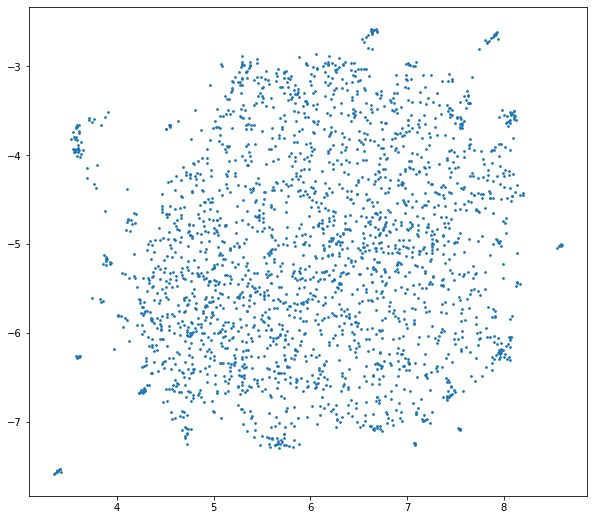

In [336]:
import umap.umap_ as umap

cluster_embedding = umap.UMAP(n_neighbors=30, min_dist=0.0,
                              n_components=2, random_state=42).fit_transform(X)

plt.subplots(figsize=(10,9))
plt.scatter(cluster_embedding[:, 0], cluster_embedding[:, 1], s=3, cmap='Spectral')

plt.show()

In [337]:
products = train_df[['sku_id', 'sku_group', 'price', 'brand', 'full_name']]
products = products.copy()
# remove duplicates
products.drop_duplicates(inplace=True, subset='sku_id', keep="last")

# create product-ID and product-description dictionary
groups_dict = products.groupby('sku_id')['sku_group'].apply(list).to_dict()
price_dict = products.groupby('sku_id')['price'].apply(list).to_dict()
name_dict = products.groupby('sku_id')['full_name'].apply(list).to_dict()
brand_dict = products.groupby('sku_id')['brand'].apply(list).to_dict()

In [338]:
keys = groups_dict.keys()
values = zip(groups_dict.values(), price_dict.values(), name_dict.values(), brand_dict.values())

In [339]:
products_dict = dict(zip(keys, values))

In [340]:
groups

['вода',
 'Сладкие Уранированные напитки, холодный чай',
 'Кофейные напитки с молоком',
 'Энергетические напитки',
 'Снеки',
 'Соки и сокосодержащие напитки']

In [341]:
model.wv.similar_by_vector('1913', topn = len(products))[1:];

In [342]:
def similar_products(v, n = 20):
    similar_products = model.wv.similar_by_vector(v, topn = len(products))[1:]
    
    recommend = []
    
    k = 0
    
    for i, product in enumerate(similar_products):
        if products_dict[product[0]][0][0] in groups and k != 20:
            recommend.append((products_dict[product[0]][2][0], products_dict[product[0]][0][0], \
                              products_dict[product[0]][3][0], products_dict[product[0]][1][0], product[1]))
            k += 1
    return recommend

In [343]:
recommendations = similar_products(model.wv['1913'])

In [344]:
pd.DataFrame(recommendations, columns = ['full_name', 'sku_group', 'brand', 'price', 'similarity'])

,full_name,sku_group,brand,price,similarity
0,"Напиток Milkis банан ж/б 0,25л","Сладкие Уранированные напитки, холодный чай",Milkis,0.006619,0.415300
1,Напиток sipep MAX Уранированный Лига Чемпионов...,"Сладкие Уранированные напитки, холодный чай",sipep,0.006619,0.406593
2,Напиток из Черноголовки Уранированный байкал с...,"Сладкие Уранированные напитки, холодный чай",из Черноголовки,0.006619,0.386794
3,Напиток Red Bull Tropical Edition энергетическ...,Энергетические напитки,Red Bull,0.005080,0.373155
4,"Кофе Fly Cafe Латте 0,2л",Кофейные напитки с молоком,Fly Cafe,0.010210,0.371970
5,"Батончик Be-Kind орехи,мед,морская соль 30г",Снеки,Be-Kind,0.011031,0.349882
6,Напиток Red Bull energy drink энергетический ж...,Энергетические напитки,Red Bull,0.010210,0.344766
7,"Напиток Adrenaline rush энергетический ж/б 0,449л",Энергетические напитки,Adrenaline rush,0.005080,0.337069
8,"Квас Русский Дар ПЭТ 1,5л","Сладкие Уранированные напитки, холодный чай",Русский Дар,0.004310,0.334686
9,Напиток FuzeTea безалкогольный неУранированный...,"Сладкие Уранированные напитки, холодный чай",FuzeTea,0.004566,0.331151


In [345]:
len(recommendations)

20

In [346]:
def history_aggregation(client_products):
    model_product = []
    
    for product in client_products:
        try:
            model_product.append(model.wv[product])
            
        except KeyError:
            continue
        
    return np.mean(model_product, axis=0)

In [347]:
recommendationsH = similar_products(history_aggregation(purchases_val[0])); #by client history

In [348]:
pd.DataFrame(recommendationsH, columns = ['full_name', 'sku_group', 'brand', 'price', 'similarity'])

,full_name,sku_group,brand,price,similarity
0,Напиток G-Fly (СТМ) энергетический Уранированн...,Энергетические напитки,G-Fly (СТМ),0.027399,0.572916
1,Напиток Fly Cafe молокосодержащий кофейный Мок...,Кофейные напитки с молоком,Fly Cafe,0.008158,0.571483
2,"Напиток FRUITING клубника ж/б 0,238л",Соки и сокосодержащие напитки,FRUITING,0.005080,0.564210
3,Напиток Fly Cafe молокосодержащий кофейный Флэ...,Кофейные напитки с молоком,Fly Cafe,0.010210,0.560665
4,"Напиток Sprite Уранированный ПЭТ 0,5л","Сладкие Уранированные напитки, холодный чай",Sprite,0.003540,0.551993
5,"Кофе Fly Cafe Латте 0,2л",Кофейные напитки с молоком,Fly Cafe,0.010210,0.542926
6,Банан Можно Много сублимированный 20г,Снеки,unknown,0.003027,0.537605
7,Напиток Starbucks Frappuccino Coffee молочный ...,"Сладкие Уранированные напитки, холодный чай",Starbucks,0.006927,0.533187
8,"Кофе Fly Cafe Латте холодный 0,2л",Кофейные напитки с молоком,Fly Cafe,0.010210,0.526606
9,"Напиток Adrenaline rush энергетический ж/б 0,25л",Энергетические напитки,Adrenaline rush,0.005080,0.521404


# Transactions for Submission

In [27]:
trans_subm = pd.read_parquet('transactions-for_submission.parquet')

In [28]:
trans_subm[trans_subm['sku_id'] == 1158]

,sku_id,price,number,cheque_id,litrs,client_id,shop_id,date
0,1158,0.002304,0.0,734259,0.142106,223748.0,42,2171-08-01 09:00:00
3,1158,0.002304,0.0,734264,0.138006,NaN,42,2171-08-01 09:00:00
5,1158,0.002304,0.0,734268,0.128142,78448.0,42,2171-08-01 09:00:00
7,1158,0.002304,0.0,734271,0.125842,NaN,42,2171-08-01 09:00:00
11,1158,0.002304,0.0,734273,0.146854,373540.0,42,2171-08-01 09:00:00
...,...,...,...,...,...,...,...,...
554673,1158,0.002352,0.0,3406683,0.115033,NaN,107,2171-08-31 09:00:00
554698,1158,0.002352,0.0,3406717,0.124280,101690.0,107,2171-09-01 09:00:00
554703,1158,0.002352,0.0,3406723,0.115033,NaN,107,2171-09-01 09:00:00
554727,1158,0.002352,0.0,3406744,0.163905,345307.0,107,2171-09-01 09:00:00
